In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore") 

### Read Pitcher data, analyze shape and NULL values

In [5]:
df_uncleaned = pd.read_csv('stats (11).csv')

print(f"DataFrame shape: {df_uncleaned.shape} \n")

print(f"Number of null values per column \n{df_uncleaned.isnull().sum()}")

DataFrame shape: (446, 68) 

Number of null values per column 
last_name                 0
 first_name               0
player_id                 0
year                      0
xwoba                     0
                       ... 
offspeed_avg_speed       58
offspeed_avg_spin        58
offspeed_avg_break_x     58
offspeed_avg_break_z     58
Unnamed: 67             446
Length: 68, dtype: int64


### Fill NaN values with 0

#### Cleaned dataframe will be called 'df'

In [6]:
# NaN values are for pitchers who don't throw a certain pitch type
df = df_uncleaned.fillna(0)

### Partition 'df' into relevant dataframes

In [7]:
# Create name df for later labeling and visual
naming_df = df[['last_name', ' first_name', 'player_id', 'year']]
print(naming_df.head())

# [4:12] = pitch outcome data : ex(Ball/Strike, Exit Velo, xwoba..)
pitch_outcome_df = df[df.columns[4:12]]
# print(pitch_outcome_df.head())

# 12:67 = out_zone_percent : offspeed_avg_break_z
pitch_metric_df = df[df.columns[12:67]]
# pitch_metric_df.columns

# [51:67] = n_fastball_formatted : offspeed_avg_break_z 
simple_metric_df = df[df.columns[51:67]]
# simple_metric_df.columns

    last_name  first_name  player_id  year
0  Wainwright        Adam     425794  2022
1     Greinke        Zack     425844  2022
2   Verlander      Justin     434378  2022
3     Sanchez      Anibal     434671  2022
4      Jansen      Kenley     445276  2022


### Pitch Outcome Kernel Density Estimators

### Pitch Outcome Kernel Density Estimators

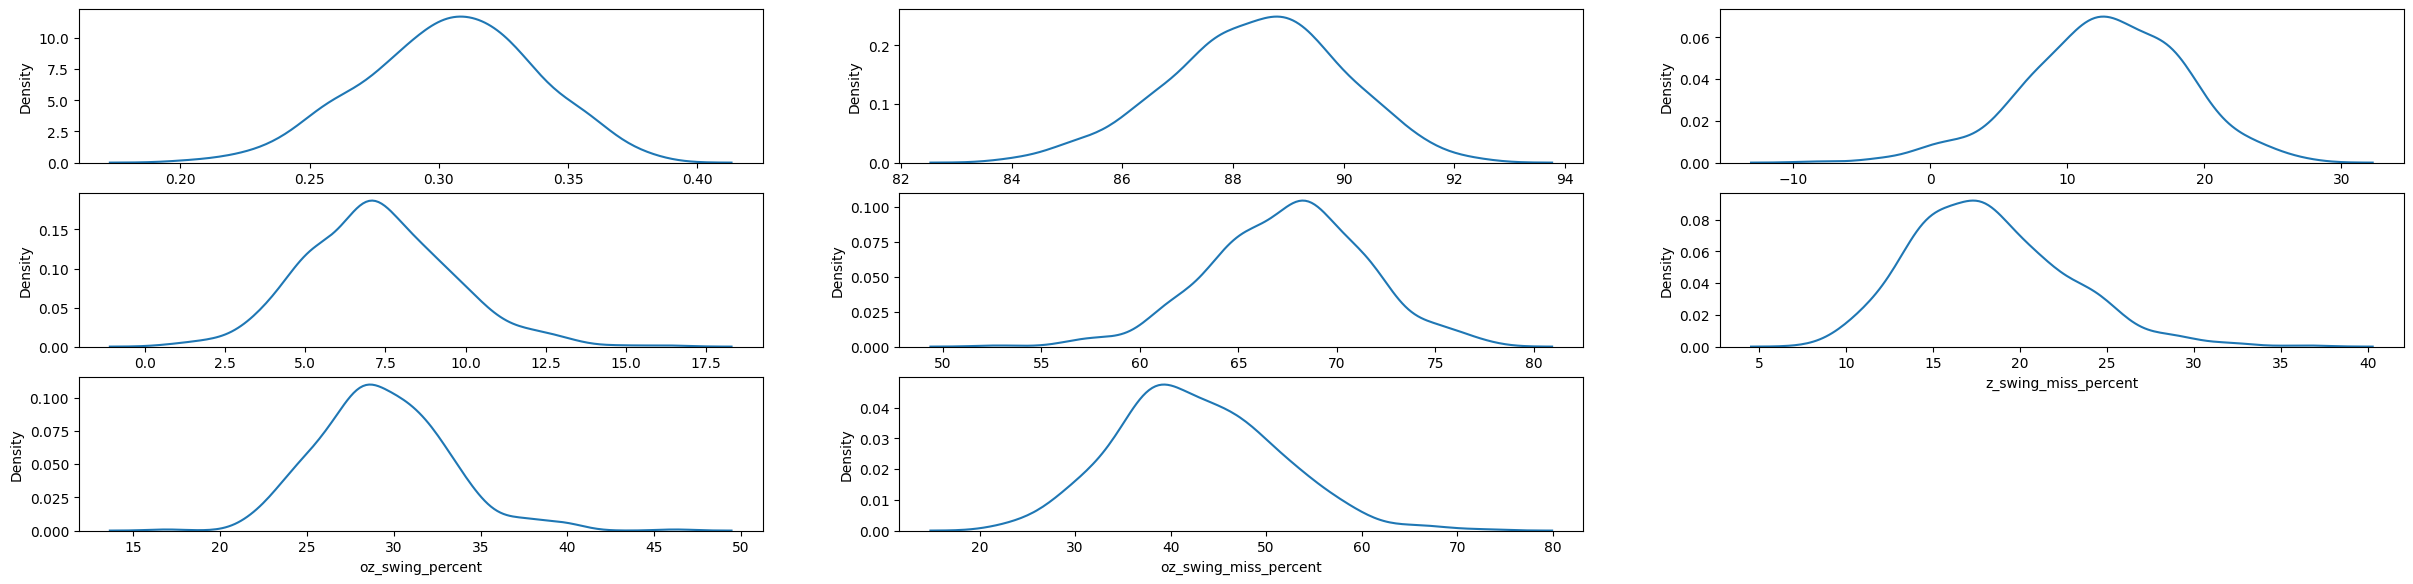

In [8]:
plt.figure(figsize=(30,45))
for i, col in enumerate(pitch_outcome_df.columns):
    if pitch_outcome_df[col].dtype != 'object':
        ax = plt.subplot(19,3, i+1)
        sns.kdeplot(pitch_outcome_df[col], ax=ax) # kernel density estimation plot
        plt.xlabel(col)

plt.show()

#### The range of values in predictors means scaling could be necessary. Since the KDE's appear gaussian, our method of scaling 'pitch_outcome_df' will be using Standardization.

Scaling pitch_outcome_df

In [9]:
# Scaling the pitch_outcome DataFrame
scalar=StandardScaler()
scaled_outcome = scalar.fit_transform(pitch_outcome_df)

# PCA for scaled_outcome pca_outcome
pca_outcome = PCA(n_components = 2)
pcs_outcome = pca_outcome.fit_transform(scaled_outcome) # PrincipalComponentS
pca_df_outcome = pd.DataFrame(data=pcs_outcome, columns=["PCA1", "PCA2"])


### Elbow method for finding K in our kmeans model

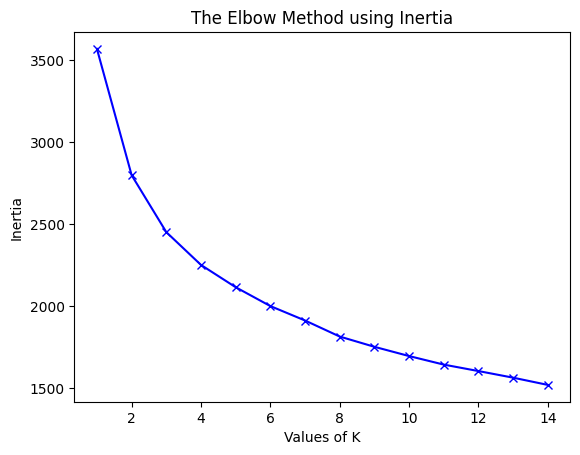

In [10]:
inertia_outcome = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters = i)
    kmean.fit_predict(pd.DataFrame(scaled_outcome))
    inertia_outcome.append(kmean.inertia_)

plt.plot(range_val,inertia_outcome,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

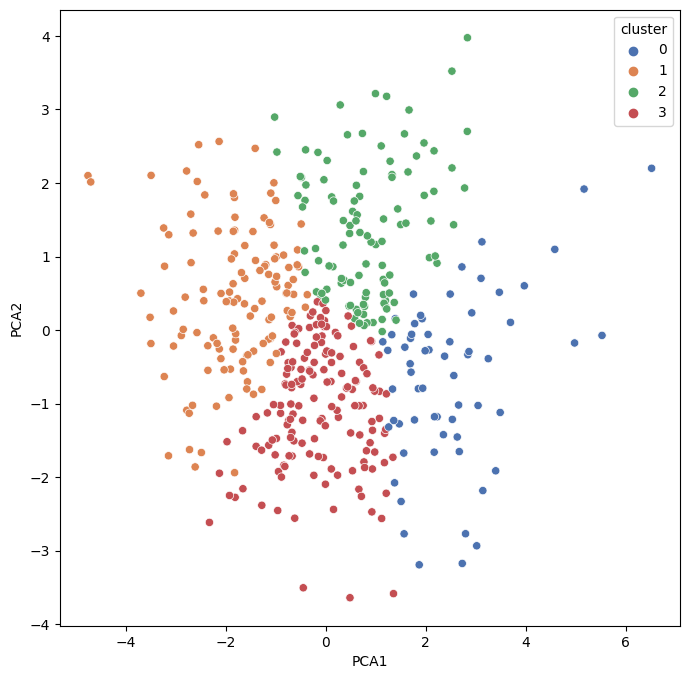

In [11]:
# Model Building using KMeans
kmeans_model_outcome = KMeans(4)
kmeans_model_outcome.fit_predict(scaled_outcome)
pca_df_kmeans_outcome= pd.concat([pca_df_outcome,pd.DataFrame({'cluster':kmeans_model_outcome.labels_})],axis=1)

# Visualizing the clustered dataframe
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans_outcome,palette='deep')

#### Concat pitcher's assigned cluster on pitch_outcome_df

- clustered_outcome_df

<Axes: xlabel='Cluster', ylabel='count'>

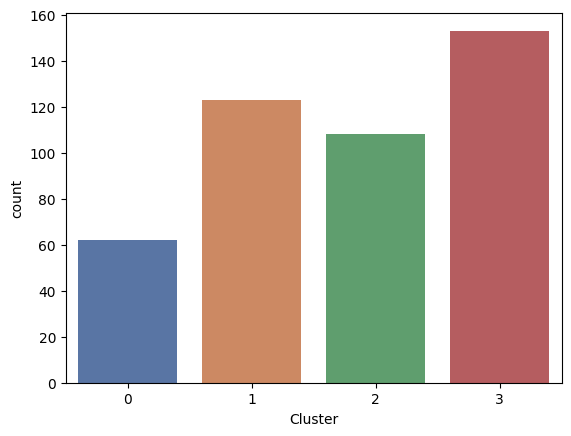

In [12]:
clustered_outcome_df = pd.concat([pitch_outcome_df, pd.DataFrame({'Cluster':kmeans_model_outcome.labels_})],axis=1)

sns.countplot(x='Cluster', data=clustered_outcome_df, palette ='deep')



Split : clustered_outcome_df

Create & Fit : DecisionTreeClassifier

Evaluate : 

In [13]:
#Split Dataset
X_outcome = clustered_outcome_df.drop(['Cluster'],axis=1)
y_outcome= clustered_outcome_df[['Cluster']]
X_train_outcome, X_test_outcome, y_train_outcome, y_test_outcome =train_test_split(X_outcome, y_outcome, test_size=0.3)


#Decision_Tree
kmeans_cluster_outcome= DecisionTreeClassifier(criterion="entropy")
kmeans_cluster_outcome.fit(X_train_outcome, y_train_outcome)
y_pred_outcome = kmeans_cluster_outcome.predict(X_test_outcome)

#Confusion_Matrix
print(metrics.confusion_matrix(y_test_outcome, y_pred_outcome))
print(classification_report(y_test_outcome, y_pred_outcome))

# 3 clusters = 72% acc
# 4 clusters = 77% acc
# 5 clusters = 72% acc
# 6 clusters = 75% acc
# 7 clusters = 61% acc

[[12  0  2  2]
 [ 1 28  1  3]
 [ 6  3 27  2]
 [ 6  8  3 30]]
              precision    recall  f1-score   support

           0       0.48      0.75      0.59        16
           1       0.72      0.85      0.78        33
           2       0.82      0.71      0.76        38
           3       0.81      0.64      0.71        47

    accuracy                           0.72       134
   macro avg       0.71      0.74      0.71       134
weighted avg       0.75      0.72      0.73       134



# This could be dicey, I'm adding name columns to clustered_outcome_df. 
# Might throw off model 
# But I want the app to show pitcher name data 

In [14]:
# clustered_outcome_df.to_csv("Clustered_Outcome.csv")

# named_clustered_outcome = clustered_outcome_df

# named_clustered_outcome['first_name'] = df[' first_name']
# named_clustered_outcome['last_name'] = df['last_name']

# named_clustered_outcome.to_csv("Named_Clustered_Outcome.csv")

In [15]:
# agg_cluster_outcome = clustered_outcome_df.groupby('Cluster').agg({'xwoba': 'mean', 'exit_velocity_avg': 'mean', 'launch_angle_avg': 'mean', 
#                                     'barrel_batted_rate': 'mean', 'z_swing_miss_percent': 'mean',
#                                     'oz_swing_percent': 'mean', 'Cluster': 'count'})

# agg_cluster_outcome.to_csv('Agg_Cluster_Outcome.csv')

print(clustered_outcome_df.groupby('Cluster').mean())

            xwoba  exit_velocity_avg  launch_angle_avg  barrel_batted_rate  \
Cluster                                                                      
0        0.266065          86.524194          8.180645            4.825806   
1        0.337382          89.752033         15.116260            9.405691   
2        0.280222          88.305556         16.869444            7.529630   
3        0.310399          88.186275          9.759477            6.368627   

         z_swing_percent  z_swing_miss_percent  oz_swing_percent  \
Cluster                                                            
0              65.308065             20.906452         32.759677   
1              68.835772             16.282114         27.208943   
2              69.620370             22.193519         30.590741   
3              65.859477             15.771242         28.720915   

         oz_swing_miss_percent  
Cluster                         
0                    48.474194  
1                    39

#### Save KMeans model [sav, pkl]
-- 

In [16]:
# #Saving Scikitlearn models
# import joblib 
# joblib.dump(kmeans_model_outcome, "model_kmeans_pitch_outcome.pkl")

# import pickle
# filename_outcome = 'kmeans_outcome.sav'
# pickle.dump(kmeans_model_outcome, open(filename_outcome, 'wb'))

# loaded_model_outcome = pickle.load(open(filename_outcome, 'rb'))
# tested_outcome = loaded_model_outcome.predict(X_test_outcome)

# eval_outcomes = classification_report(y_test_outcome, y_pred_outcome)
# print(eval_outcomes)

# END OF OUTCOME CLUSTER SECTION
# END OF OUTCOME CLUSTER SECTION
# END OF OUTCOME CLUSTER SECTION
# END OF OUTCOME CLUSTER SECTION

# Beginning of Simple Pitch Metric Section
# Beginning of Simple Pitch Metric Section
# Beginning of Simple Pitch Metric Section
# Beginning of Simple Pitch Metric Section

### Simple Pitch Metric Kernel Density Estimators

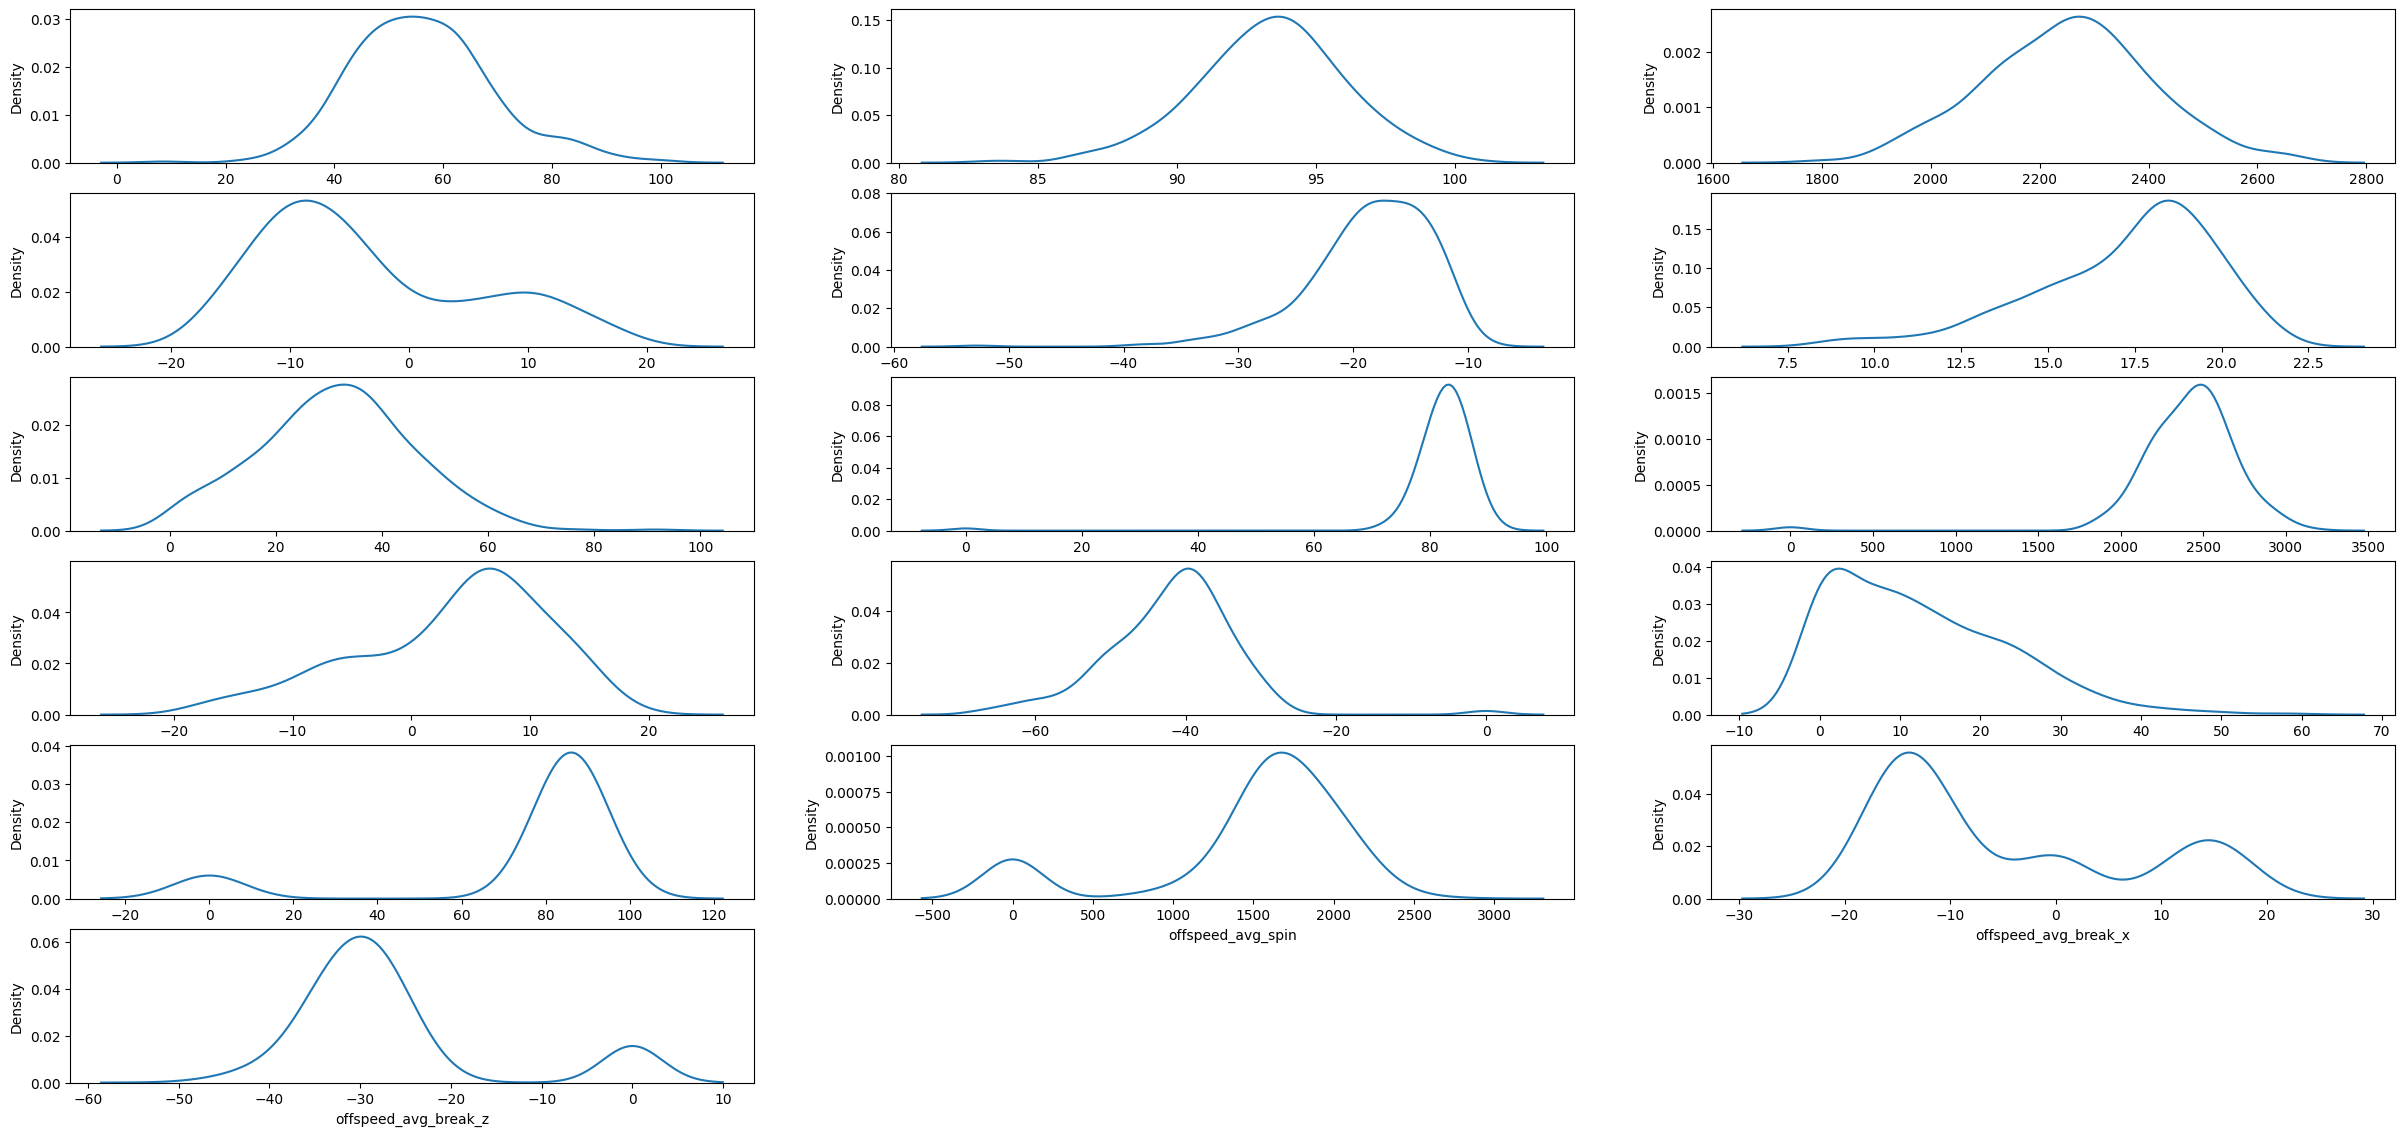

In [17]:
plt.figure(figsize=(30,45))
for i, col in enumerate(simple_metric_df.columns):
    if simple_metric_df[col].dtype != 'object':
        ax = plt.subplot(19,3, i+1)
        sns.kdeplot(simple_metric_df[col], ax=ax) # kernel density estimation plot
        plt.xlabel(col)

plt.show()



#### The range of values in predictors means scaling could be necessary. Since the KDE's do not appear gaussian, our method of scaling 'pitch_metric_df' and 'simple_metric_df' will be using Normalization

In [18]:
from sklearn.preprocessing import RobustScaler

scalar=StandardScaler()

rs_simple_metric = scalar.fit_transform(simple_metric_df)
rs_metric = scalar.fit_transform(pitch_metric_df)

pca_simple = PCA(n_components=2)
pca_metric = PCA(n_components=2)

pcs_simple = pca_simple.fit_transform(rs_simple_metric) # PrincipalComponentS
pcs_metric = pca_metric.fit_transform(rs_metric) # PrincipalComponentS

pca_df_simple = pd.DataFrame(data = pcs_simple, columns = ["PCA1", "PCA2"])
pca_df_metric = pd.DataFrame(data = pcs_metric, columns = ["PCA1", "PCA2"])



#### Elbow method for simple and full pitch metric 

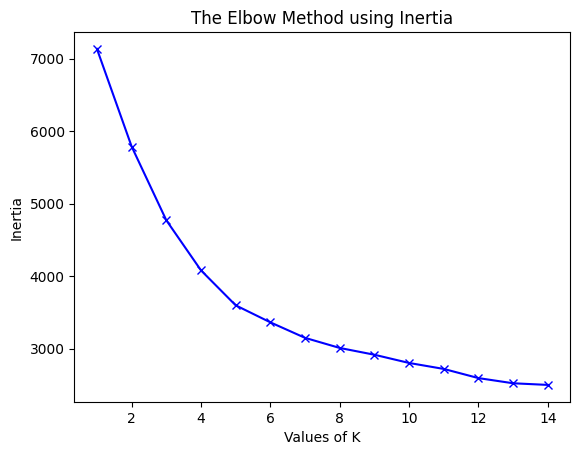

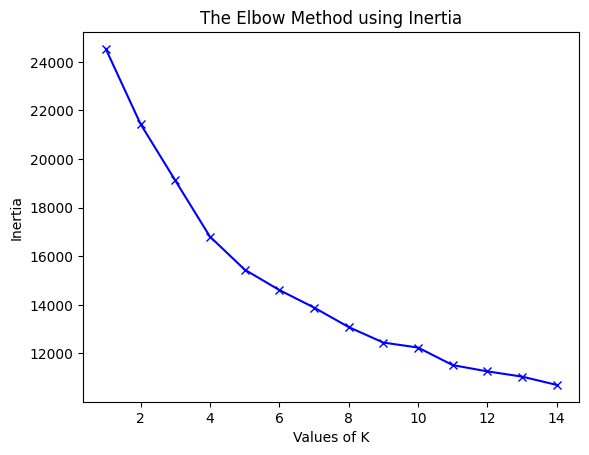

In [19]:
inertia_simple = []
range_val = range(1,15)
for i in range_val:
    kmean_s = KMeans(n_clusters = i)
    kmean_s.fit_predict(pd.DataFrame(rs_simple_metric))
    inertia_simple.append(kmean_s.inertia_)

plt.plot(range_val,inertia_simple,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

inertia_metric = []
for i in range_val:
    kmean_m = KMeans(n_clusters = i)
    kmean_m.fit_predict(pd.DataFrame(rs_metric))
    inertia_metric.append(kmean_m.inertia_)

plt.plot(range_val,inertia_metric,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


<Axes: xlabel='PCA1', ylabel='PCA2'>

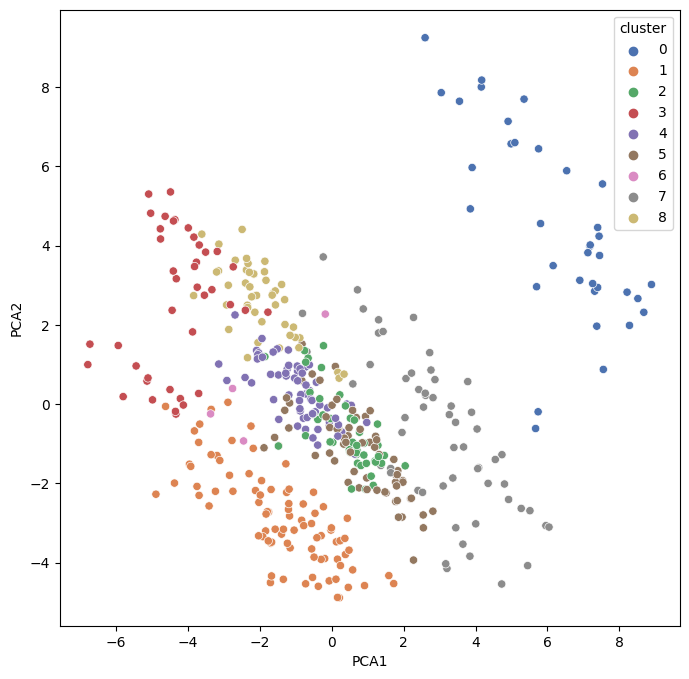

In [20]:
kmeans_model_simple = KMeans(5)
kmeans_model_metric = KMeans(9)

kmeans_model_simple.fit_predict(rs_simple_metric)
kmeans_model_metric.fit_predict(rs_metric)

pca_df_kmeans_simple= pd.concat([pca_df_simple,pd.DataFrame({'cluster':kmeans_model_simple.labels_})],axis=1)
pca_df_kmeans_metric= pd.concat([pca_df_metric,pd.DataFrame({'cluster':kmeans_model_metric.labels_})],axis=1)

# Visualizing the clustered dataframe
plt.figure(figsize=(8,8))
# sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans_simple,palette='deep')
sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans_metric,palette='deep')

<Axes: xlabel='Cluster', ylabel='count'>

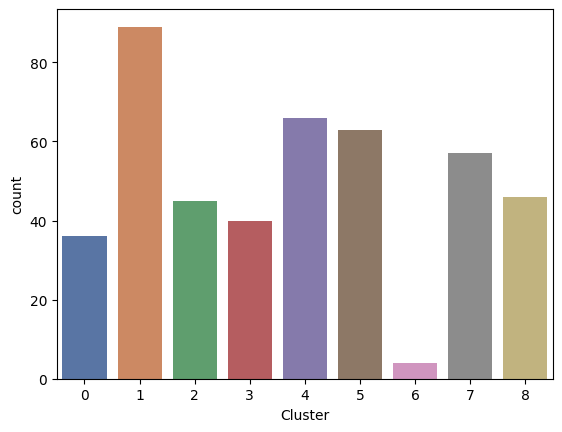

In [21]:
clustered_simple_df = pd.concat([simple_metric_df, pd.DataFrame({'Cluster': kmeans_model_simple.labels_})], axis=1)

clustered_metric_df = pd.concat([pitch_metric_df, pd.DataFrame({'Cluster': kmeans_model_metric.labels_})], axis=1)

sns.countplot(x='Cluster', data=clustered_metric_df, palette ='deep')


Split : clustered_outcome_df

Create & Fit : DecisionTreeClassifier

Evaluate : 

In [22]:
#### Pitch Outcome Data ######
#Split Dataset
X_outcome = clustered_outcome_df.drop(['Cluster'],axis=1)
y_outcome= clustered_outcome_df[['Cluster']]
X_train_outcome, X_test_outcome, y_train_outcome, y_test_outcome =train_test_split(X_outcome, y_outcome, test_size=0.3)

#Decision_Tree
kmeans_cluster_outcome= DecisionTreeClassifier(criterion="entropy")
kmeans_cluster_outcome.fit(X_train_outcome, y_train_outcome)
y_pred_outcome = kmeans_cluster_outcome.predict(X_test_outcome)

#Confusion_Matrix
print(metrics.confusion_matrix(y_test_outcome, y_pred_outcome))
print(classification_report(y_test_outcome, y_pred_outcome))

# 3 clusters = 72% acc
# 4 clusters = 77% acc
# 5 clusters = 72% acc
# 6 clusters = 75% acc
# 7 clusters = 61% acc

#### Simple pitch data ######
#Split Dataset
X_simple = clustered_simple_df.drop(['Cluster'],axis=1)
y_simple= clustered_simple_df[['Cluster']]
X_train_simple, X_test_simple, y_train_simple, y_test_simple =train_test_split(X_simple, y_simple, test_size=0.3)

#### Full Pitch Metric data ######
#Split Dataset
X_metric = clustered_metric_df.drop(['Cluster'],axis=1)
y_metric= clustered_metric_df[['Cluster']]
X_train_metric, X_test_metric, y_train_metric, y_test_metric =train_test_split(X_metric, y_metric, test_size=0.3)


[[ 9  0  1  0]
 [ 0 30  4  7]
 [ 4  2 22  2]
 [ 7  8  5 33]]
              precision    recall  f1-score   support

           0       0.45      0.90      0.60        10
           1       0.75      0.73      0.74        41
           2       0.69      0.73      0.71        30
           3       0.79      0.62      0.69        53

    accuracy                           0.70       134
   macro avg       0.67      0.75      0.69       134
weighted avg       0.73      0.70      0.71       134



### Simple KMeans model 
#### Decision Tree Classifier for evaluation


In [23]:
##### Pitch Outcome Evaluation #####
#Decision_Tree
kmeans_cluster_outcome= DecisionTreeClassifier(criterion="entropy")
kmeans_cluster_outcome.fit(X_train_outcome, y_train_outcome)
y_pred_outcome = kmeans_cluster_outcome.predict(X_test_outcome)

eval_outcomes = classification_report(y_test_outcome, y_pred_outcome)



#### Simple Pitch Data Evaluation ####
#Decision_Tree
kmeans_cluster_simple= DecisionTreeClassifier(criterion="entropy")
kmeans_cluster_simple.fit(X_train_simple, y_train_simple)
y_pred_simple = kmeans_cluster_simple.predict(X_test_simple)

eval_simple = classification_report(y_test_simple, y_pred_simple)


#### Full Pitch Metric Evaluation ####
#Decision Tree
kmeans_cluster_metric= DecisionTreeClassifier(criterion="entropy")
kmeans_cluster_metric.fit(X_train_metric, y_train_metric)
y_pred_metric = kmeans_cluster_metric.predict(X_test_metric)

eval_metric = classification_report(y_test_metric, y_pred_metric)

# print(pitch_outcome_df.info()) # 8 predictors
# print(simple_metric_df.info()) # 16 predictors
# print(pitch_metric_df.info()) # 55 predictors

# print(eval_simple)
# print(eval_simple)
# 4 clusters = 96%
# 5 clusters = 92%
# kmeans_model_simple = KMeans(5)
# kmeans_model_metric = KMeans(9)


# KMeans Clustering Model File Outputs

In [25]:
##########################################
####### Saving Outcome Pitch Model #######
##########################################
# print(pitch_outcome_df.info()) # 8 predictors
import joblib 
import pickle 

joblib.dump(kmeans_model_outcome, "model_kmeans_pitch_outcome.pkl")

filename_outcome = 'kmeans_outcome.sav'
pickle.dump(kmeans_model_outcome, open(filename_outcome, 'wb'))

loaded_model_outcome = pickle.load(open(filename_outcome, 'rb'))
tested_outcome = loaded_model_outcome.predict(X_test_outcome)

eval_outcomes = classification_report(y_test_outcome, y_pred_outcome)





##########################################
####### Saving Simple Pitch Model ########
##########################################
# print(simple_metric_df.info()) # 16 predictors

joblib.dump(kmeans_model_simple, 'model_kmeans_simple.pkl')

filename_simple = 'kmeans_simple.sav'
pickle.dump(kmeans_model_simple, open(filename_simple, 'wb'))

loaded_model_simple = pickle.load(open(filename_simple, 'rb'))
tested_simple = loaded_model_simple.predict(X_test_simple)

eval_simple = classification_report(y_test_simple, y_pred_simple) # Classification evaluation 90+%




##########################################
####### Saving Simple Pitch Model ########
##########################################
# print(pitch_metric_df.info()) # 55 predictors

joblib.dump(kmeans_model_metric, 'model_kmeans_pitch_metrics.pkl')


filename_metric = 'kmeans_metric.sav'
pickle.dump(kmeans_model_metric, open(filename_metric, 'wb'))

loaded_model_metric = pickle.load(open(filename_metric, 'rb'))
tested_metric = loaded_model_metric.predict(X_test_metric)

eval_metric = classification_report(y_test_metric, y_pred_metric) 


# Clustered Model To CSV File Outputs

In [26]:
# Includes predictors + First, Last, Cluster

##########################################
####### Outcome Pitch CSV          #######
##########################################

clustered_outcome_df.to_csv("Clustered_Outcome.csv")

named_clustered_outcome = clustered_outcome_df
named_clustered_outcome['last_name'] = df['last_name']
named_clustered_outcome['first_name'] = df[' first_name']

named_clustered_outcome.to_csv("Named_Clustered_Outcome.csv")

# Includes predictors + First, Last, Cluster

##########################################
####### Outcome Simple Pitch  CSV  #######
##########################################

clustered_simple_df.to_csv('Clustered_Simple.csv')

name_clustered_simple = clustered_simple_df
name_clustered_simple['last_name'] = df['last_name']
name_clustered_simple['first_name'] = df[' first_name']

name_clustered_simple.to_csv("Named_Clustered_Simple.csv")



# Includes predictors + First, Last, Cluster

##########################################
####### Outcome Full Metric CSV    #######
##########################################

clustered_metric_df.to_csv('Clustered_Metric.csv')

name_clustered_metric = clustered_metric_df
name_clustered_metric['last_name'] = df['last_name']
name_clustered_metric['first_name'] = df[' first_name']

name_clustered_metric.to_csv("Name_Clustered_Metric.csv")


# print(clustered_simple_df.info())
# named_simple = clustered_simple_df

# named_simple['first_name'] = df[' first_name']
# named_simple['last_name'] = df['last_name']

# named_simple.to_csv("Named_Simple_Clustered.csv")

# agg_cluster_simple = clustered_simple_df.groupby('Cluster').mean()

# agg_cluster_simple.to_csv("Agg_Cluster_Simple.csv")

# print(clustered_simple_df.info())


# Aggregated CSV Outputs, groupby('Cluster')

In [27]:
# agg_cluster_outcome = clustered_outcome_df.groupby('Cluster').agg({'xwoba': 'mean', 'exit_velocity_avg': 'mean', 'launch_angle_avg': 'mean', 
#                                     'barrel_batted_rate': 'mean', 'z_swing_miss_percent': 'mean',
#                                     'oz_swing_percent': 'mean'})

# agg_cluster_outcome.to_csv('Agg_Cluster_Outcome.csv')


# print(clustered_outcome_df.groupby('Cluster').mean())

print(clustered_simple_df.groupby('Cluster').max())
# print(clustered_metric_df)

         n_fastball_formatted  fastball_avg_speed  fastball_avg_spin  \
Cluster                                                                
0                        98.8               100.2               2656   
1                        85.2                98.4               2521   
2                        78.8               100.8               2659   
3                       100.0                94.2               2495   
4                        91.9                97.2               2611   

         fastball_avg_break_x  fastball_avg_break_z  fastball_avg_break  \
Cluster                                                                   
0                        17.1                  -9.5                21.1   
1                        18.3                 -11.1                21.8   
2                         0.3                  -8.2                21.5   
3                         1.9                 -15.8                19.7   
4                         3.6                

# Metric Kmeans model


In [28]:

kmeans_cluster_metric= DecisionTreeClassifier(criterion="entropy")
kmeans_cluster_metric.fit(X_train_metric, y_train_metric)
y_pred_metric = kmeans_cluster_metric.predict(X_test_metric)

print(metrics.confusion_matrix(y_test_metric, y_pred_metric))
print(classification_report(y_test_metric, y_pred_metric))

# 7 clusters = 93%
# 8 clusters = 95%
# 9 clusters = 95%
# 10 clusters = 98%

[[ 8  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  2]
 [ 0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0 13  1  0  0  0]
 [ 0  1  0  0  0 20  0  0  1]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 19  0]
 [ 0  0  0  0  0  1  0  0 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.97      1.00      0.98        29
           2       1.00      0.88      0.94        17
           3       0.92      1.00      0.96        11
           4       1.00      0.93      0.96        14
           5       0.91      0.91      0.91        22
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00        19
           8       0.80      0.92      0.86        13

    accuracy                           0.95       134
   macro avg       0.84      0.85      0.85       134
weighted avg       0.94      0.95      0.94       134



In [29]:
# kmeans_model_metric = KMeans(9)
joblib.dump(kmeans_model_metric, 'model_kmeans_pitch_metrics.pkl')

clustered_metric_df.to_csv('Clustered_Metric.csv')

named_metric = clustered_metric_df

named_metric['first_name'] = df[' first_name']
named_metric['last_name'] = df['last_name']

named_metric.to_csv("Named_Pitch_Metric_Clustered.csv")



In [30]:
agg_clustered_pitch_metric = clustered_metric_df.groupby('Cluster').mean()

agg_clustered_pitch_metric.to_csv("Agg_Cluster_Pitch_Metric.csv")

